In [23]:
# ✅ Import Required Libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import matplotlib.pyplot as plt


In [24]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# ✅ Enable Mixed Precision for Faster Computation
tf.keras.mixed_precision.set_global_policy('mixed_float16')


In [26]:
# ✅ Define Paths
reference_file = "/content/drive/MyDrive/Jan 4/Reference_Output_Until_Jan02_2025 (4).csv"
predictor_folder = "/content/drive/MyDrive/Jan 4/5000_X_12_Until_Jan02_2025"



In [27]:
reference_df = pd.read_csv(reference_file)  # Columns: Reading_File_Name, A, B, reading_id, gender, etc.

In [28]:
# ✅ Extract Target (Omron Diastolic)
y = reference_df[['Omron Diastolic']].to_numpy(dtype=np.float32)


In [29]:
# ✅ Normalize Target Values
from sklearn.preprocessing import StandardScaler
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y)


In [30]:
# Save target scaler
joblib.dump(target_scaler, "/content/drive/MyDrive/pkl files/target_scaler18.pkl")


['/content/drive/MyDrive/pkl files/target_scaler18.pkl']

In [31]:
# ✅ Load and Process Predictor Files in a Single Pass
aggregated_data = []
predictor_files = sorted([f for f in os.listdir(predictor_folder) if f.endswith(".csv")])



In [32]:
for file in predictor_files:
    df = pd.read_csv(os.path.join(predictor_folder, file), dtype=np.float32)

    # Handle missing values
    df.fillna(df.median(numeric_only=True), inplace=True)

    aggregated_data.append(df.to_numpy(dtype=np.float32))




In [33]:
# ✅ Convert to NumPy Array
X = np.array(aggregated_data, dtype=np.float32)


In [34]:
# ✅ Ensure Proper Shape for GRU (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])


In [35]:
X_2D = X.reshape(-1,X.shape[2])


In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_2D)


In [37]:
X_3D = X_scaled.reshape(X.shape[0], X.shape[1], X.shape[2])

In [38]:
# ✅ Split Data (20% Test, 80% Train)
X_3Dtrain, X_3Dtest, y_train, y_test = train_test_split(X_3D, y_scaled, test_size=0.2, random_state=42)




In [39]:
X_3Dtest.shape

(108, 5000, 12)

In [40]:
y_train

array([[ 0.8159395 ],
       [-0.49639365],
       [ 0.53472525],
       [-0.49639365],
       [-1.3400364 ],
       [ 0.8159395 ],
       [ 0.44098717],
       [ 0.06603482],
       [ 0.06603482],
       [-1.0588222 ],
       [ 0.34724906],
       [-1.3400364 ],
       [-1.5275127 ],
       [-0.68386984],
       [-0.68386984],
       [-1.2462983 ],
       [-1.3400364 ],
       [ 0.06603482],
       [ 0.06603482],
       [-1.1525602 ],
       [-0.7776079 ],
       [ 0.25351098],
       [ 0.34724906],
       [-1.2462983 ],
       [-0.12144134],
       [ 2.0345345 ],
       [ 1.6595821 ],
       [-0.40265557],
       [-1.5275127 ],
       [-0.49639365],
       [ 0.8159395 ],
       [-0.49639365],
       [ 0.6284633 ],
       [-0.49639365],
       [ 0.6284633 ],
       [-1.2462983 ],
       [-0.871346  ],
       [ 0.1597729 ],
       [-0.68386984],
       [ 0.44098717],
       [-0.49639365],
       [-0.59013176],
       [ 0.44098717],
       [-0.7776079 ],
       [ 1.0034157 ],
       [ 0

In [19]:
# ✅ Define a Lightweight GRU Model for Faster Training
model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),
    GRU(128, return_sequences=True, activation='tanh'),
    Dropout(0.2),
    BatchNormalization(),
    GRU(64, return_sequences=False, activation='tanh'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(1, dtype=tf.float32)  # Output layer (1 target)
])



In [41]:
# ✅ Compile Model with Adam Optimizer
optimizer = Adam(learning_rate=0.0005, clipvalue=0.5)
model.compile(optimizer=optimizer, loss= 'mae', metrics=['mse', 'mae'])



In [42]:
from tensorflow.keras.utils import plot_model


In [43]:
history = model.fit(
    X_3Dtrain, y_train,
    epochs=100,
    batch_size=128,  # Larger batch for speed
    validation_data=(X_3Dtest, y_test),
    verbose=1,

)




Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 491ms/step - loss: 0.6957 - mae: 0.6957 - mse: 0.8288 - val_loss: 0.6989 - val_mae: 0.6989 - val_mse: 0.8538
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - loss: 0.6823 - mae: 0.6823 - mse: 0.7883 - val_loss: 0.7038 - val_mae: 0.7038 - val_mse: 0.8389
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step - loss: 0.6493 - mae: 0.6493 - mse: 0.7253 - val_loss: 0.7239 - val_mae: 0.7239 - val_mse: 0.8404
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step - loss: 0.6887 - mae: 0.6887 - mse: 0.8319 - val_loss: 0.7219 - val_mae: 0.7219 - val_mse: 0.8277
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 420ms/step - loss: 0.7001 - mae: 0.7001 - mse: 0.8089 - val_loss: 0.7131 - val_mae: 0.7131 - val_mse: 0.8179
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 410ms/step - loss: 0.6862 - mae: 0.6862 - mse: 0.8129 - val_loss: 0.7087 - val_mae: 0.7087 - val_mse: 0.8173
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 496ms/step - loss: 0.6783 - mae: 0.6783 - mse: 0.8025 - val_loss: 

In [44]:
# ✅ Predict on Test Data
y_pred = model.predict(X_3Dtest)



4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


In [45]:
 # ✅ Inverse Transform Predictions
y_pred_original = target_scaler.inverse_transform(y_pred)
y_test_original = target_scaler.inverse_transform(y_test)



In [46]:
# ✅ Compute MSE and MAE (Original Scale)
final_mse = mean_squared_error(y_test_original, y_pred_original)
final_mae = mean_absolute_error(y_test_original, y_pred_original)


In [47]:
print(f"✅ Final MSE: {final_mse:.4f}")
print(f"✅ Final MAE: {final_mae:.4f}")


✅ Final MSE: 98.2531
✅ Final MAE: 7.7791


In [48]:
y_pred_original

array([[ 86.71338 ],
       [ 86.33586 ],
       [ 81.87294 ],
       [ 90.12388 ],
       [ 80.87063 ],
       [ 94.09708 ],
       [ 84.65702 ],
       [ 89.892235],
       [ 95.65055 ],
       [ 90.973   ],
       [ 77.36894 ],
       [ 81.62408 ],
       [ 80.589325],
       [ 77.685585],
       [ 80.387856],
       [ 85.03921 ],
       [ 84.68732 ],
       [ 80.722885],
       [ 97.59198 ],
       [ 83.00907 ],
       [ 79.94362 ],
       [ 82.8825  ],
       [ 87.1223  ],
       [ 90.95216 ],
       [101.26833 ],
       [ 86.959946],
       [ 81.81511 ],
       [ 95.75923 ],
       [ 91.17704 ],
       [ 77.36672 ],
       [ 80.70744 ],
       [ 84.51765 ],
       [ 90.576614],
       [ 83.14953 ],
       [ 77.070206],
       [ 87.70856 ],
       [ 85.33207 ],
       [ 77.33349 ],
       [111.77464 ],
       [ 79.584595],
       [ 76.36617 ],
       [ 84.6187  ],
       [ 97.87244 ],
       [ 81.636986],
       [ 91.22325 ],
       [ 92.72924 ],
       [ 84.936226],
       [ 94.8

In [49]:
y_test_original

array([[107.],
       [ 87.],
       [ 94.],
       [ 96.],
       [ 82.],
       [ 76.],
       [ 76.],
       [ 98.],
       [ 82.],
       [103.],
       [ 78.],
       [109.],
       [ 78.],
       [ 82.],
       [ 96.],
       [ 81.],
       [ 89.],
       [ 79.],
       [ 78.],
       [ 78.],
       [ 87.],
       [ 87.],
       [ 96.],
       [ 90.],
       [ 70.],
       [ 88.],
       [ 97.],
       [ 89.],
       [ 92.],
       [ 94.],
       [ 90.],
       [ 80.],
       [ 98.],
       [ 93.],
       [ 81.],
       [ 91.],
       [ 81.],
       [ 89.],
       [114.],
       [ 74.],
       [ 88.],
       [ 93.],
       [ 95.],
       [ 78.],
       [ 97.],
       [ 91.],
       [ 73.],
       [ 95.],
       [ 79.],
       [ 76.],
       [ 74.],
       [ 89.],
       [ 75.],
       [ 90.],
       [ 94.],
       [ 70.],
       [ 89.],
       [101.],
       [ 82.],
       [100.],
       [ 98.],
       [ 71.],
       [ 74.],
       [ 77.],
       [ 75.],
       [ 81.],
       [ 7

In [50]:
correlation = np.corrcoef(y_test_original[:, 0], y_pred_original[:, 0])[0, 1]  # Assuming Omron Diastolic is in the first column


Correlation between y_test_original and y_pred_original: 0.3136


Text(0.5, 1.0, 'Omron Systolic Prediction')

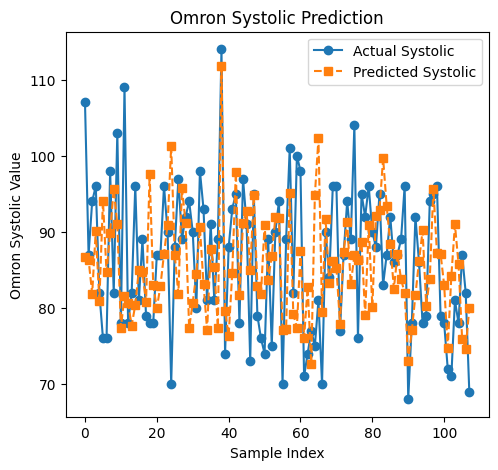

In [51]:
# ✅ Graphical Representation
plt.figure(figsize=(12, 5))

# Plot Omron Diastolic
plt.subplot(1, 2, 1)
plt.plot(y_test_original[:, 0], label="Actual Diastolic", marker='o')
plt.plot(y_pred_original[:, 0], label="Predicted Diastolic", linestyle='dashed', marker='s')
plt.xlabel("Sample Index")
plt.ylabel("Omron Systolic Value")
plt.legend()
plt.title("Omron Systolic Prediction")

